## Variational Autoencoders

    花式解释AutoEncoder与VAE
    https://zhuanlan.zhihu.com/p/27549418

### Introduction
#### The variational autoencoder (VAE) is arguably the simplest setup that realizes deep probabilistic modeling. 
## The class of models is quite broad: basically any (unsupervised) density estimator with latent random variables

    Want to find a mapping function (nonlinear) map from z to x.

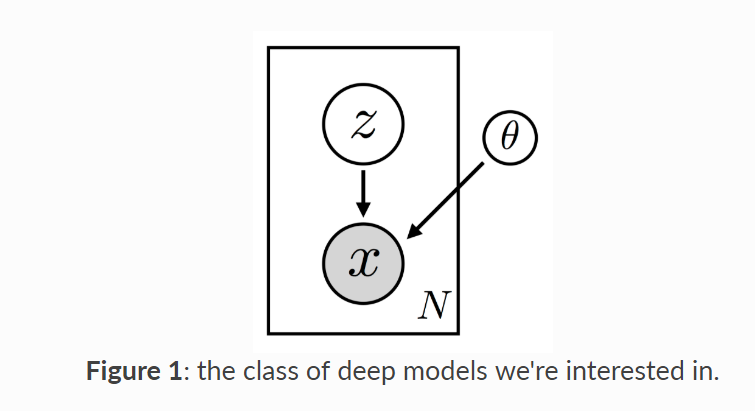

In [1]:
from IPython.display import Image
Image("figure 1.png", width=500, height=500)

    x: datapoint
    z: latent random variable 
    θ: parameters 
    
    Finally, what’s of particular importance here is that we allow for each xi to depend on zi in a complex, non-linear way.
    Of course this non-linear structure is also one reason why this class of models offers a very flexible approach to modeling complex data. 
    
    Consequently in order to do inference in this model we need to specify a flexibly family of guides (i.e. variational distributions).
    Recall that the job of the guide is to ‘guess’ good values for the latent random variable
    
    Amortization means that, rather than introducing variational parameters {λi}, we instead learn a function that maps each xi to an appropriate λi.

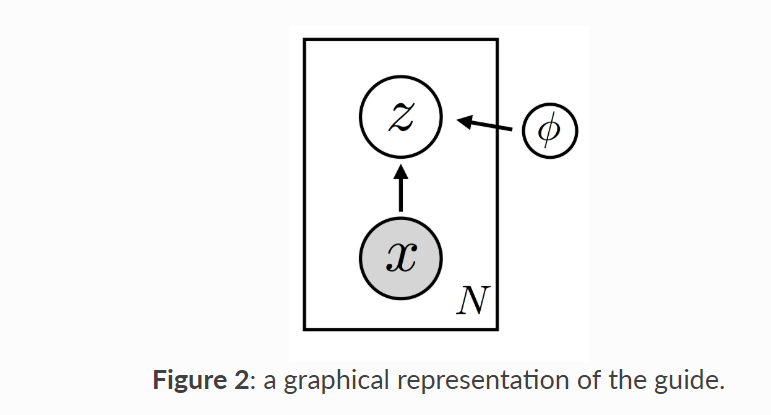

In [2]:
from IPython.display import Image
Image("figure 2.png", width=500, height=500)

    We thus end up with a parameterized family of distributions over the latent z space that can be instantiated for all N datapoint xi 
    Note that the guide qϕ(z|x) is parameterized by a global parameter ϕ shared by all the datapoints. 
    
     The goal of inference will be to find ‘good’ values for θ and ϕ so that two conditions are satisfied:
     . the log evidence logpθ(x) is large. this means our model is a good fit to the data
     . the guide qϕ(z|x) provides a good approximation to the posterior

#### Figure 1 (model) is decoder, while Figure 2 (guide) is decoder

## Autoencoder
    Once we’ve learned good values for θ and ϕ we can also go through the following exercise.
        we start with a given image x
        using our guide we encode it as z
        using the model likelihood we decode z and get a reconstructed image xreco
    

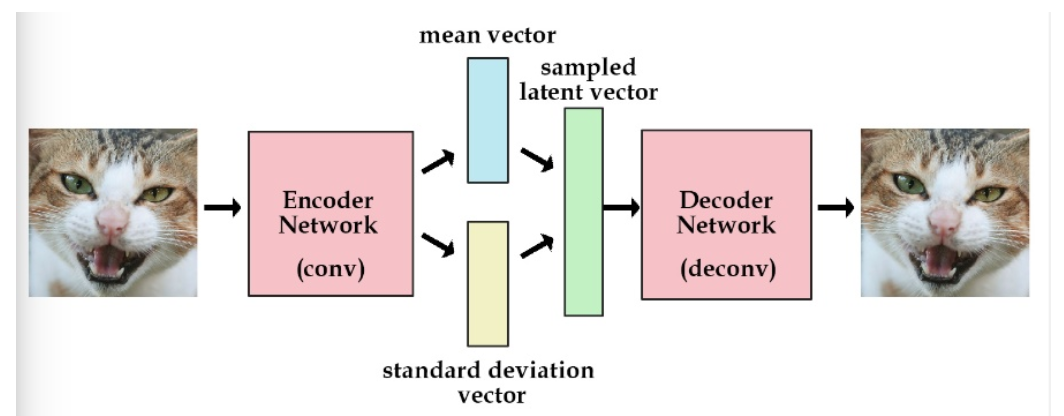

In [3]:
Image("figure 3.png", width=500, height=500)

### VAE in Pyro
    The dataset we’re going to model is MNIST, a collection of images of handwritten digits.

In [4]:
import os

import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
# Trace_ELBO --> loss="ELBO" instead?
from pyro.infer import SVI
from pyro.optim import Adam

In [5]:
#pyro.enable_validation(True)
#pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [6]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    # normalize value to [0, 1]
    trans = transforms.ToTensor()
    train_set = dset.MNIST(root=root, train=True, transform=trans,
                           download=download)
    test_set = dset.MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

    decoder network:
    Given a latent code z, the forward call of Decoder returns the parameters for a Bernoulli distribution in image space. Since each image is of size 28×28=784, log_img is of size batch_size x 784.

In [7]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        # setup the non-linearities
        
        # softplus: another activation function
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z (like 1-dim code)
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        
        # loc_img size: batch_size * 784 (28 * 28)
        return loc_img

    encoder network:
    Given an image x the forward call of Encoder returns a mean and covariance that together parameterize a (diagonal) Gaussian distribution in latent space.

In [8]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Encoder, self).__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        #x = torch.reshape(x, (-1, 784))
        #x = x.view(-1, 784)
        
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        
        # z_loc, z_scale represents parameters of Gaussain Distribution
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

    With our encoder and decoder networks in hand, we can now write down the stochastic functions that represent our model and guide. First the model:

In [9]:
# define the model p(x|z)p(z)
def model(self, x):
    # register PyTorch module `decoder` with Pyro
    pyro.module("decoder", self.decoder)
    # we specifically designate independence amongst the data in our mini-batch
    with pyro.iarange("data", x.size(0)): 
        # !!! setup hyperparameters for prior p(z)
        z_loc = x.new_zeros(torch.Size((x.size(0), self.z_dim)))
        z_scale = x.new_ones(torch.Size((x.size(0), self.z_dim)))
        # sample from prior (value will be sampled by guide when computing the ELBO)
        z = pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))
        # decode the latent code z
        loc_img = self.decoder.forward(z)
        # score against actual images
        # I think this line of code compared observed data (x) to guessed img (loc_img)
        # independent(1) means that it gets independent in Guassian distribution in a high-dim vevtor way
        # Not indepent(0): if it is not unit gaussain distribution, independent on first dim will not cause real independence
        pyro.sample("obs", dist.Bernoulli(loc_img).independent(1), obs=x.reshape(-1, 784))

In [10]:
# define the guide (i.e. variational distribution) q(z|x)
def guide(self, x):
    # register PyTorch module `encoder` with Pyro
    pyro.module("encoder", self.encoder)
    with pyro.iarange("data", x.size(0)):
        # use the encoder to get the parameters used to define q(z|x)
        z_loc, z_scale = self.encoder.forward(x)
        # sample the latent code z
        pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))

    Crucially, we use the same name for the latent random variable as we did in the model: 'latent'

In [11]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.iarange("data", x.size(0)):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.size(0), self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.size(0), self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).independent(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.iarange("data", x.size(0)):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

### Inference

In [12]:
vae = VAE()

In [13]:
optimizer = Adam({"lr": 1.0e-3})

In [14]:
svi = SVI(vae.model, vae.guide, optimizer, loss="ELBO")

    Train/Test: svi.step / svi.evaluate_loss
    This function will compute an estimate of the ELBO but won’t take any gradient steps.

In [15]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for _, (x, _) in enumerate(train_loader):
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [16]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for i, (x, _) in enumerate(test_loader):
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

    About reconstruct_img(): 
    If we’ve learned a good model and guide—in particular if we’ve learned a good latent representation—this plurality of z samples will correspond to different styles of digit writing, and the reconstructed images should exhibit an interesting variety of different styles.
    如果是普通的Auto Encoder的話，應該只會變出一種風格的字跡而已
    因為VAE是從sample in latent space using the gaussian distribution provided by the encoder產生的

### Code and Sample results

In [17]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False

# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 100
TEST_FREQUENCY = 5

In [18]:
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss="ELBO")

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

RuntimeError: addmm(): argument 'mat1' (position 1) must be Variable, not torch.FloatTensor